In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize = 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr


# Estimating high-coverage Mez2-AMH divergence time

try complete.cases including ustishim

In [2]:
gt <- read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, tv_only = TRUE)

In [3]:
step1 <- run_step1(gt)

In [5]:
tafr <- step1 %>% summarise_if(is.numeric, mean)
tafr

a,b,c,d,e,f,total,mut_rate,tmrca_afr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
710.7692,0.1538462,3.384615,132.3846,10.46154,683.5385,5730293,4.727748e-10,254514.4


In [6]:
calculate_direct <- function(archaic, capture, mindp) {
    gt <- read_genotypes(archaic, capture, mindp = mindp, maxdp = 0.98, tv_only = TRUE) %>%
        .[, c("chrom", "pos", "a00", "chimp", archaic)] %>% filter(complete.cases(.))

    tibble(
        name = archaic,
        arch = sum(gt$a00 == gt$chimp & gt[[archaic]] != gt$chimp),
        hum = sum(gt[[archaic]] == gt$chimp & gt$a00 != gt$chimp),
        anc = sum(gt[[archaic]] == gt$a00 & gt$a00 != gt$chimp),
        total = nrow(gt),
        dp = mindp
     )
}

In [9]:
mez2_full <- future_map_dfr(1:20, function(i) calculate_direct("mez2", "full", i))

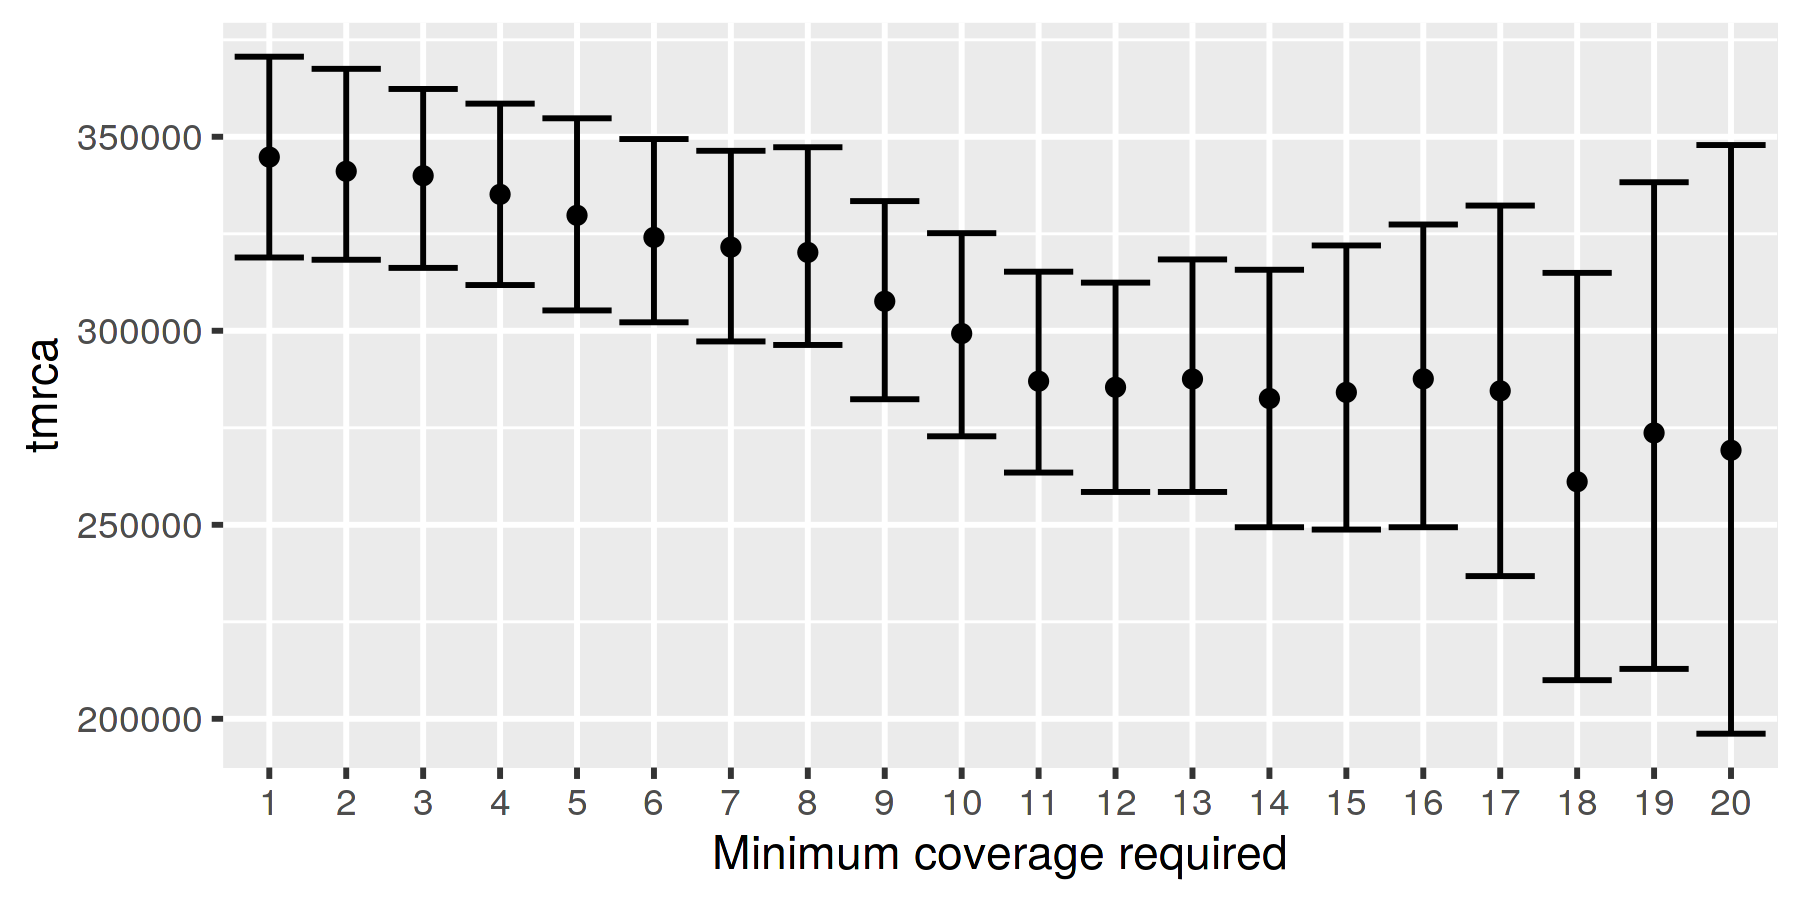

In [10]:
set_dim(6, 3)

mez2_full %>%
mutate(mut_rate = tafr$mut_rate,
       tmrca = hum / (total * mut_rate)) %>%
mutate(pmap(list(hum, total, mut_rate), function(hum, total, mut_rate) {
    counts <- rpois(1000, hum) / (total * mut_rate)
    ci <- quantile(counts, probs = c(0.025, 0.975), na.rm = TRUE)
    tibble(lower = ci[1], upper = ci[2])
    })) %>%
unnest %>%
ggplot(aes(as.factor(dp), tmrca)) +
    geom_point() +
    geom_errorbar(aes(ymin = lower, ymax = upper)) +
    xlab("Minimum coverage required")

In [23]:
mez2_sub <-
    map_dfr(1:10, function(mindp) {
        future_map_dfr(1:10, function(i) { calculate_direct(paste0("mez2_dp", i), "full", mindp) })
    })

Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”Warning message:
“Removed 12 rows containing missing values (geom_point).”Warning message:
“Removed 12 rows containing missing values (geom_errorbar).”

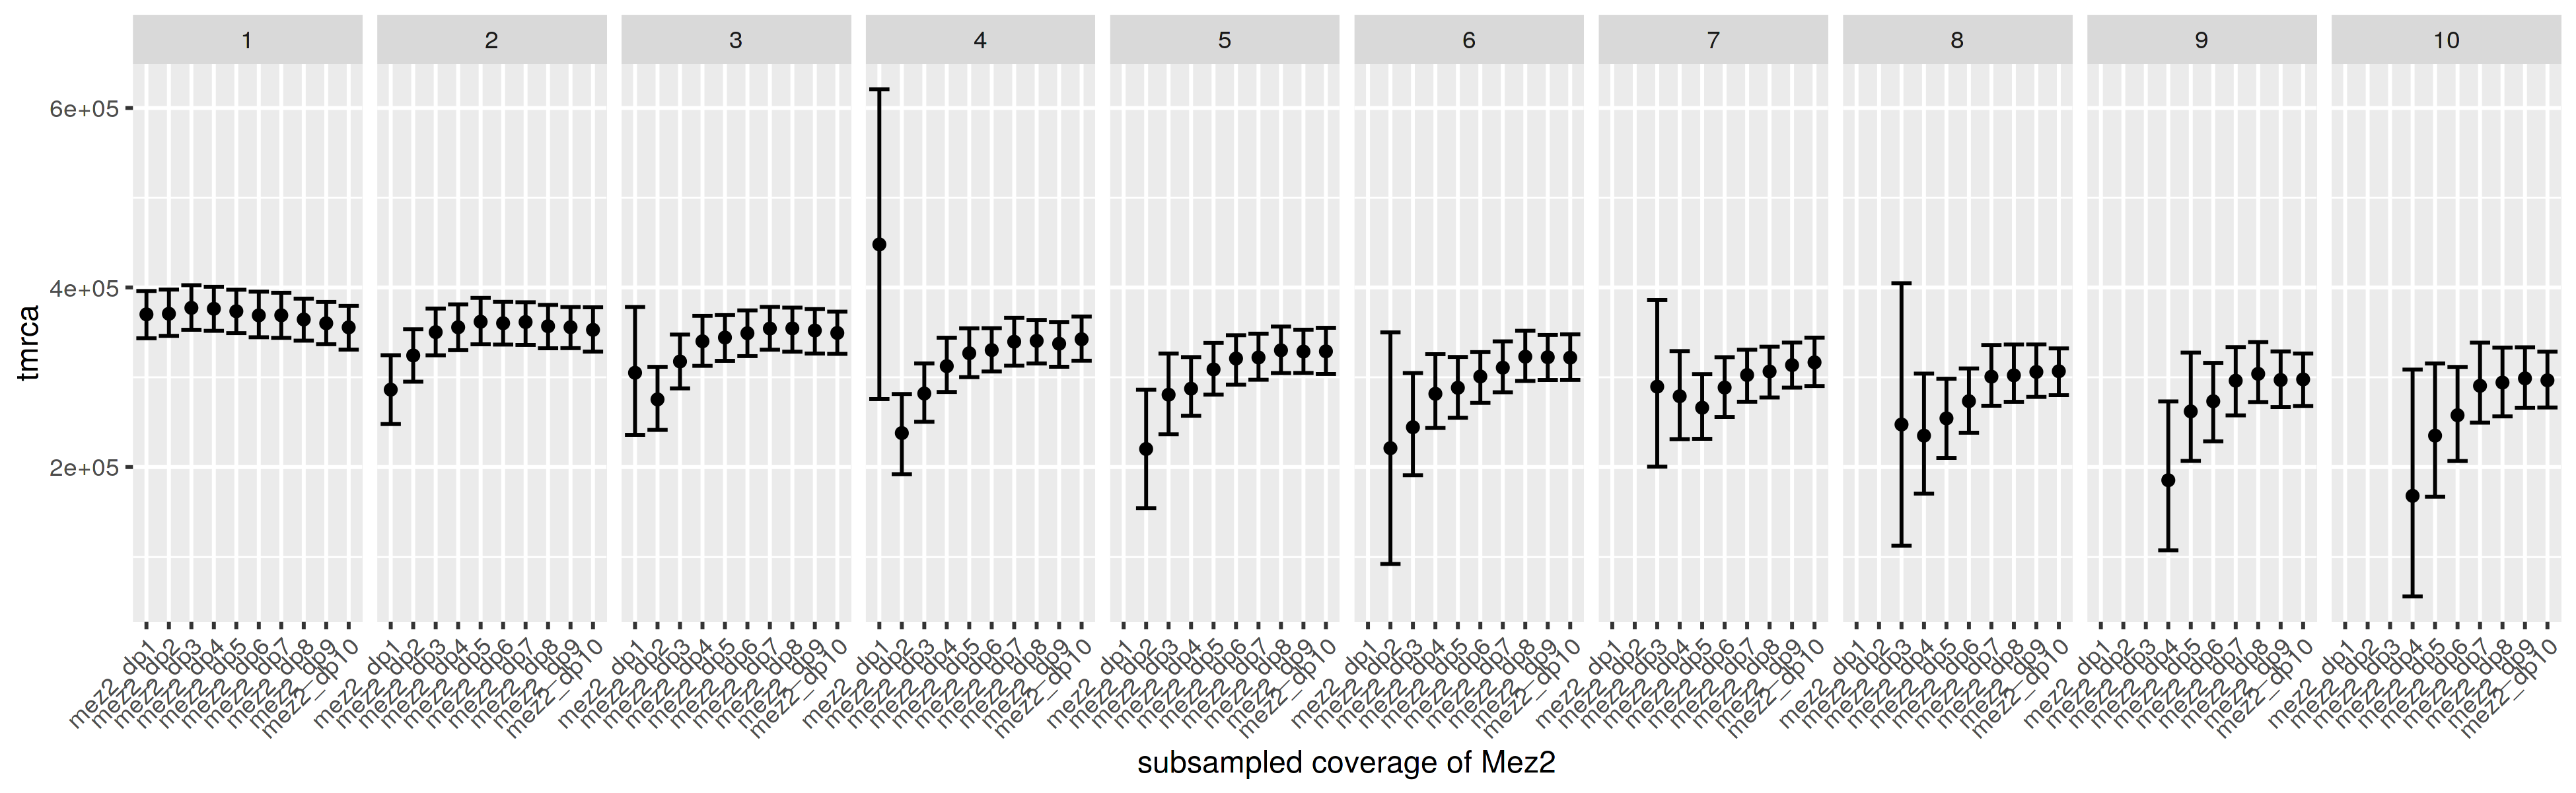

In [32]:
set_dim(13, 4)

mez2_sub %>%
mutate(mut_rate = tafr$mut_rate,
       tmrca = hum / (total * mut_rate)) %>%
mutate(pmap(list(hum, total, mut_rate), function(hum, total, mut_rate) {
    counts <- rpois(1000, hum) / (total * mut_rate)
    ci <- quantile(counts, probs = c(0.025, 0.975), na.rm = TRUE)
    tibble(lower = ci[1], upper = ci[2])
    })) %>%
unnest %>%
ggplot(aes(fct_relevel(name, levels = paste0("mez2_dp", 1:10)), tmrca)) +
    geom_point() +
    geom_errorbar(aes(ymin = lower, ymax = upper)) +
    xlab("subsampled coverage of Mez2") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    facet_grid(. ~ dp)